---
format: 
  html:
    toc: true
execute:
  echo: true
  code-fold: true
---

# K-Means Clustering Analysis

This analysis will categorize Pennsylvania counties into distinct clusters based on their socioeconomic index, median household income, educational attainment, poverty rates, unemployment, and local park coverage. These clusters will help to identify areas in Pennsylvania where government resources could be strategically allocated to address disparities.

In [1]:
#| echo: false
# This chunk is hidden on the webiste. It just reloads the pa_counties dataframe in this notebook.
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

API_KEY = '0da0c882151e10740c1a0a844cf845096bedb565'
c = Census(API_KEY)

acs_data = c.acs5.state_county(
    fields=[
        'NAME',         # County name
        'B01003_001E',  # Total population
        'B15003_001E',  # Population 25+
        'B19013_001E',  # Median household income
        'B19301_001E',  # Per capita income
        'B01002_001E',  # Median age
        'B02001_002E',  # White population
        'B02001_003E',  # African American population
        'B03001_003E',  # Hispanic population
        'B15003_017E',  # High school graduates
        'B15003_022E',  # Bachelor’s degree holders
        'B25077_001E',  # Median housing value
        'B17001_002E',  # Population below poverty line
    ],
    state_fips=states.PA.fips,
    county_fips="*"
)

acs_df = pd.DataFrame(acs_data)
acs_df.columns = [
    'County',  # Name of the county
    'Total Population',
    'Population Over 25',
    'Median Household Income', 
    'Per Capita Income', 
    'Median Age', 
    'White Population', 
    'African American Population', 
    'Hispanic Population', 
    'High School Graduates', 
    'Bachelors Degree Holders', 
    'Median Housing Value', 
    'Population Below Poverty Line',
    'State',  
    'County_Name'
]

acs_df['County'] = acs_df['County'].str.replace(" County, Pennsylvania", "", case=False)
acs_df['County'] = acs_df['County'].str.upper()
acs_df.drop(columns=['State'], inplace=True)

geojson_path = "/Users/ryanswett/Downloads/Python/Final_Project/PaCounty2024_11.geojson"
county_data = gpd.read_file(geojson_path)
counties = county_data.merge(
    acs_df,
    left_on='FIPS_COUNT',
    right_on='County_Name',
    how='left'
)

counties['Percent_White'] = counties['White Population'] / counties['Total Population']*100 # Percent white
counties['Percent_Black'] = counties['African American Population'] / counties['Total Population']*100 # Percent black
counties['Percent_Hispanic'] = counties['Hispanic Population'] / counties['Total Population']*100 # Percent hispanic
counties['Percent_HS_degrees'] = counties['High School Graduates'] / counties['Total Population']*100 # Percent high school grads
counties['Percent_Bachelors'] = counties['Bachelors Degree Holders'] / counties['Population Over 25']*100 # Percent bachelors
counties['Percent_Poverty'] = counties['Population Below Poverty Line'] / counties['Population Over 25']*100 # Percent below poverty line

parks_path = "/Users/ryanswett/Downloads/Python/Final_Project/DCNR_LocalPark202406/DCNR_LocalPark202406.shp"
parks_data = gpd.read_file(parks_path)

parks_data = parks_data.drop(columns=['STATUS', 'PARK_FEE', 'ALT_NAME', 'PREMISE_AD', 'PREMISE_CI', 'PREMISE_ZI', 'YEAR_OPEN',
                                     'PREMISE_CR', 'URL', 'COMMENTS', 'ATV', 'Basketball', 'Bicycling', 'Camping', 'Canoeing_K',
                                     'CrossCount', 'Disc_Golf', 'Dog_Park', 'Equestrian', 'Fishing', 'Fitness_Eq', 'Golf',
                                     'Hiking', 'Horseback_', 'Hunting', 'Ice_Fishin', 'Ice_Skatin', 'Motor_Boat', 'LWCF_Restr',
                                     'Mountain_B', 'Natural_Wi', 'Organized_', 'Parking', 'Pavilion', 'Pets_Allow', 'Playground',
                                     'Restrooms', 'Rock_Climb', 'Scenic_Vie', 'Sledding', 'Sports_Fie', 'Swimming', 'Tennis_Cou',
                                     'Theatre_Am', 'Trails', 'Visitor_Ce', 'White_Wate', 'Wildlife_W', 'Amenity_Co', 'Feedback_l',
                                     'Skate_Park'])

updated_parks = parks_data.groupby('PREMISE_CO')['Acres'].sum().reset_index()
updated_parks['park_sq_mi'] = updated_parks['Acres'] / 640
updated_parks['PREMISE_CO'] = updated_parks['PREMISE_CO'].str.upper()

parks = counties.merge(
    updated_parks,
    left_on='County',  
    right_on='PREMISE_CO',  
    how='left')

parks['Percent Local Park'] = parks['park_sq_mi'] / parks['AREA_SQ_MI'] * 100

unemp_data = pd.read_csv("/Users/ryanswett/Downloads/Python/Final_Project/unemp.csv")
unemp_data['County'] = unemp_data['County'].str.replace('County', '', case=False).str.strip()
unemp_data['County'] = unemp_data['County'].str.upper()

pa_counties = unemp_data.merge(
    parks,
    left_on='County', 
    right_on='County', 
    how='left')

pa_counties.rename(columns={"Value (Percent)": "Unemp Rate"}, inplace=True)

pa_counties['Median Household Income'] = pd.to_numeric(pa_counties['Median Household Income'], errors='coerce')
pa_counties['Percent_Bachelors'] = pd.to_numeric(pa_counties['Percent_Bachelors'], errors='coerce')
pa_counties['Percent_Poverty'] = pd.to_numeric(pa_counties['Percent_Poverty'], errors='coerce')
pa_counties['Median Household Income'].fillna(0, inplace=True)
pa_counties['Percent_Bachelors'].fillna(0, inplace=True)
pa_counties['Percent_Poverty'].fillna(0, inplace=True)

scaler = MinMaxScaler()
variables = pa_counties[['Median Household Income', 'Percent_Bachelors', 'Percent_Poverty']].copy()
variables = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

pa_counties['Socioeconomic_Index'] = (
    variables['Median Household Income'] +
    variables['Percent_Bachelors'] -
    variables['Percent_Poverty']
)

pa_counties = gpd.GeoDataFrame(pa_counties, geometry=pa_counties['geometry'])

# Ensure the GeoDataFrame has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Ensure all variables are numeric and handle NaN values
pa_counties['Median Household Income'] = pd.to_numeric(pa_counties['Median Household Income'], errors='coerce')
pa_counties['Percent_Bachelors'] = pd.to_numeric(pa_counties['Percent_Bachelors'], errors='coerce')
pa_counties['Percent_Poverty'] = pd.to_numeric(pa_counties['Percent_Poverty'], errors='coerce')

# Fill NaN values
pa_counties['Median Household Income'].fillna(0, inplace=True)
pa_counties['Percent_Bachelors'].fillna(0, inplace=True)
pa_counties['Percent_Poverty'].fillna(0, inplace=True)

# Normalize variables
scaler = MinMaxScaler()
variables = pa_counties[['Median Household Income', 'Percent_Bachelors', 'Percent_Poverty']].copy()
variables = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

# Calculate Socioeconomic Index
pa_counties['Socioeconomic_Index'] = (
    variables['Median Household Income'] +
    variables['Percent_Bachelors'] -
    variables['Percent_Poverty']
)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ryanswett/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


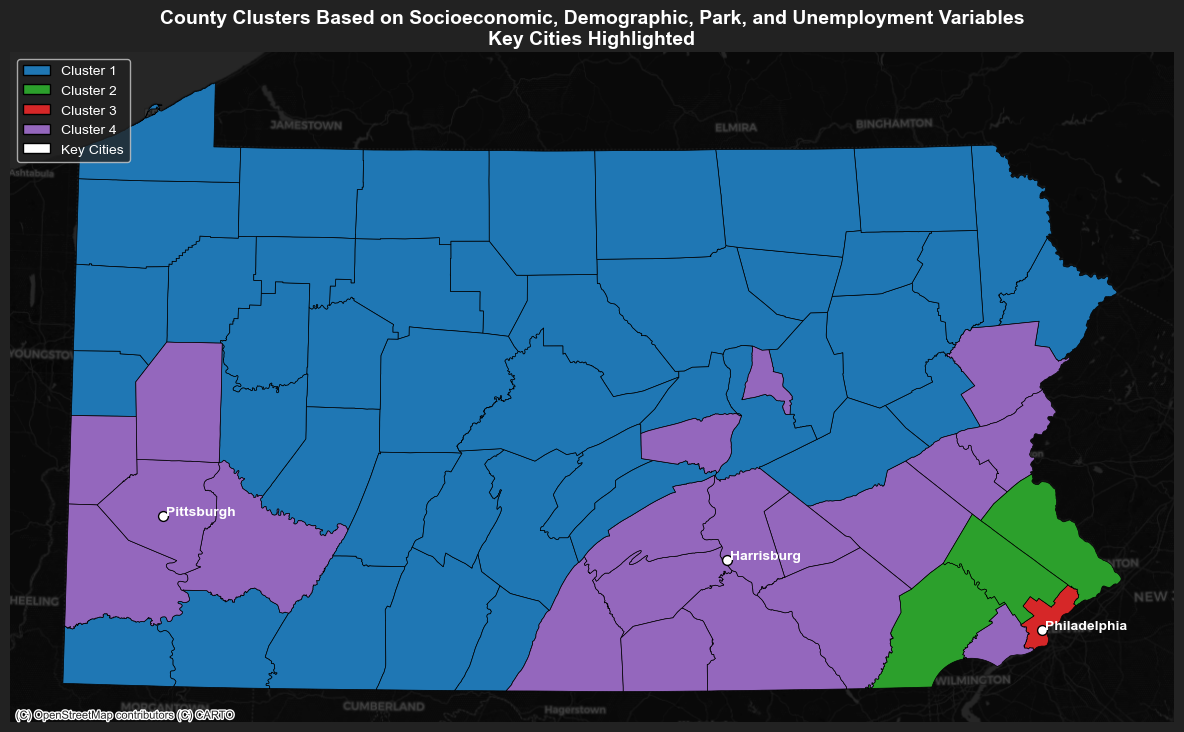

Cluster Summary:
         Socioeconomic_Index  Median Household Income  Percent_Bachelors  \
Cluster                                                                    
1                  -0.531187                -0.534398          -0.490793   
2                   3.148042                 3.381667           2.761867   
3                  -1.533165                -0.724491           0.652393   
4                   0.746505                 0.677930           0.608305   

         Percent_Poverty  Percent Local Park  Unemp Rate  
Cluster                                                   
1               0.315406           -0.385381    0.195631  
2              -1.855439            1.058408   -0.560242  
3               4.137164            6.117241    2.876745  
4              -0.606666            0.363946   -0.480407  


In [26]:
#| echo: true
#| code-fold: true
clustering_vars = [
    'Socioeconomic_Index', 
    'Median Household Income', 
    'Percent_Bachelors', 
    'Percent_Poverty', 
    'Percent Local Park',
    'Unemp Rate'  
]

pa_counties[clustering_vars] = pa_counties[clustering_vars].apply(pd.to_numeric, errors='coerce')
for var in clustering_vars:
    pa_counties[var].fillna(pa_counties[var].median(), inplace=True)

scaler = StandardScaler()
pa_counties[clustering_vars] = scaler.fit_transform(pa_counties[clustering_vars])

pa_counties = pa_counties[pa_counties['geometry'].notnull()]

kmeans = KMeans(n_clusters=4, random_state=42)
pa_counties['Cluster'] = kmeans.fit_predict(pa_counties[clustering_vars])
pa_counties['Cluster'] = pa_counties['Cluster'] + 1  

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

pastel_colors = {
    1: "#1f77b4",  
    2: "#2ca02c",  
    3: "#d62728",  
    4: "#9467bd"  
}
pa_counties['color'] = pa_counties['Cluster'].map(pastel_colors)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    color=pa_counties['color'],
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', edgecolor='black', markersize=50, label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

legend_elements = [
    Patch(facecolor=pastel_colors[1], edgecolor='black', label='Cluster 1'),
    Patch(facecolor=pastel_colors[2], edgecolor='black', label='Cluster 2'),
    Patch(facecolor=pastel_colors[3], edgecolor='black', label='Cluster 3'),
    Patch(facecolor=pastel_colors[4], edgecolor='black', label='Cluster 4'),
    Patch(facecolor='white', edgecolor='black', label='Key Cities')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, labelcolor='white')


plt.title("County Clusters Based on Socioeconomic, Demographic, Park, and Unemployment Variables\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold', color='white')
ax.axis("off")
plt.tight_layout()
plt.show()

cluster_summary = pa_counties.groupby('Cluster')[clustering_vars].mean()
print("Cluster Summary:")
print(cluster_summary)

Talking Points for Policymakers: Suggestions Based on Cluster Analysis

This analysis categorizes Pennsylvania counties into four distinct clusters based on their socioeconomic index, median household income, educational attainment, poverty rates, unemployment, and local park coverage. These clusters help us identify areas where government resources could be strategically allocated to address disparities.

**Cluster 1: Rural, Low Socioeconomic Status Counties (Blue)**

Characteristics:

- Socioeconomic Status: Low (below average), with significantly lower household income and lower levels of educational attainment.

- Poverty: Slightly above average poverty levels.

- Unemployment: Slightly higher than the average unemployment rate.

- Access to Parks: Below average.


Policy Recommendations:

- Job Creation & Workforce Development: Invest in job creation programs and provide more job training to improve workforce skills.

- Poverty Reduction & Education: Increase social safety nets (e.g., housing, food assistance) and expand access to education and vocational training to improve long-term economic opportunities.


**Cluster 2: Economically Thriving Counties (Green)**

Characteristics:

- Socioeconomic Status: High, with significantly higher household incomes and higher educational attainment.

- Poverty: Very low poverty levels.

- Unemployment: Very low unemployment rates.

- Access to Parks: Above average.

Policy Recommendations:

- Aside from working to maintain economic stability, this cluster does not need much policy intervention.


**Cluster 3: Developing Urban Counties (Red)**

Characteristics:

- Socioeconomic Status: Low, with low household incomes and limited educational attainment.

- Poverty: Very high, much higher than average.

- Unemployment: Very high, indicating economic distress.

- Access to Parks: High, which might suggest a focus on recreation despite economic challenges.

Policy Recommendations:

- Economic Revitalization: Implement job creation and infrastructure development programs to boost economic activity and reduce unemployment.

- Social Support & Education: Provide social services to alleviate poverty (e.g., housing, healthcare) and improve access to education and vocational training to enhance future job prospects.


**Cluster 4: Moderate Socioeconomically with Low Unemployment Counties (Purple)**

Characteristics:

- Socioeconomic Status: Moderate, with slightly above average household income and moderate educational attainment.

- Poverty: Low, slightly below the average.

- Unemployment: Low, indicating a stable labor market.

- Access to Parks: Slightly above average.


Policy Recommendations:

- Promote Economic Diversification: Encourage the development of new industries and small businesses, particularly in tech, clean energy, and advanced manufacturing, to ensure long-term economic growth.

- Strengthen Community Infrastructure: Improve public services, such as education, healthcare, and transportation, to enhance the overall quality of life and support continued stability.

Broader Policy Implications

Targeted Resource Allocation:

- Clusters 1 and 4 should be prioritized for state and federal resources to address entrenched economic disparities.

- Parks in Cluster 3, while abundant, should be maintained through state support to ensure accessibility and functionality.

Regional Collaboration:

- Use thriving counties in Cluster 3 as a model for economic development and park infrastructure improvements in struggling areas.

- Equity in Policy Implementation:
    
- Ensure that policies account for the unique challenges of rural areas (Cluster 1) versus more urbanized high-poverty areas (Cluster 2).

This cluster analysis highlights the need for data-driven policy decision-naking tailored to the strengths and challenges of each cluster. By targeting investments where they are most needed, the state can foster more equitable development and improve outcomes for residents statewide.

Within-Cluster Characteristics Summary:
         Median Household Income ($)  Population Below Poverty Line (%)  \
Cluster                                                                   
1                          -0.534398                        9700.976744   
2                           3.381667                       39788.333333   
3                          -0.724491                      351811.000000   
4                           0.677930                       29706.050000   

         Bachelor's Degree Holders (%)  Local Park Coverage (%)  \
Cluster                                                           
1                            -0.490793                -0.385381   
2                             2.761867                 1.058408   
3                             0.652393                 6.117241   
4                             0.608305                 0.363946   

         Unemployment Rate (%)  Total Population  
Cluster                                           
1   

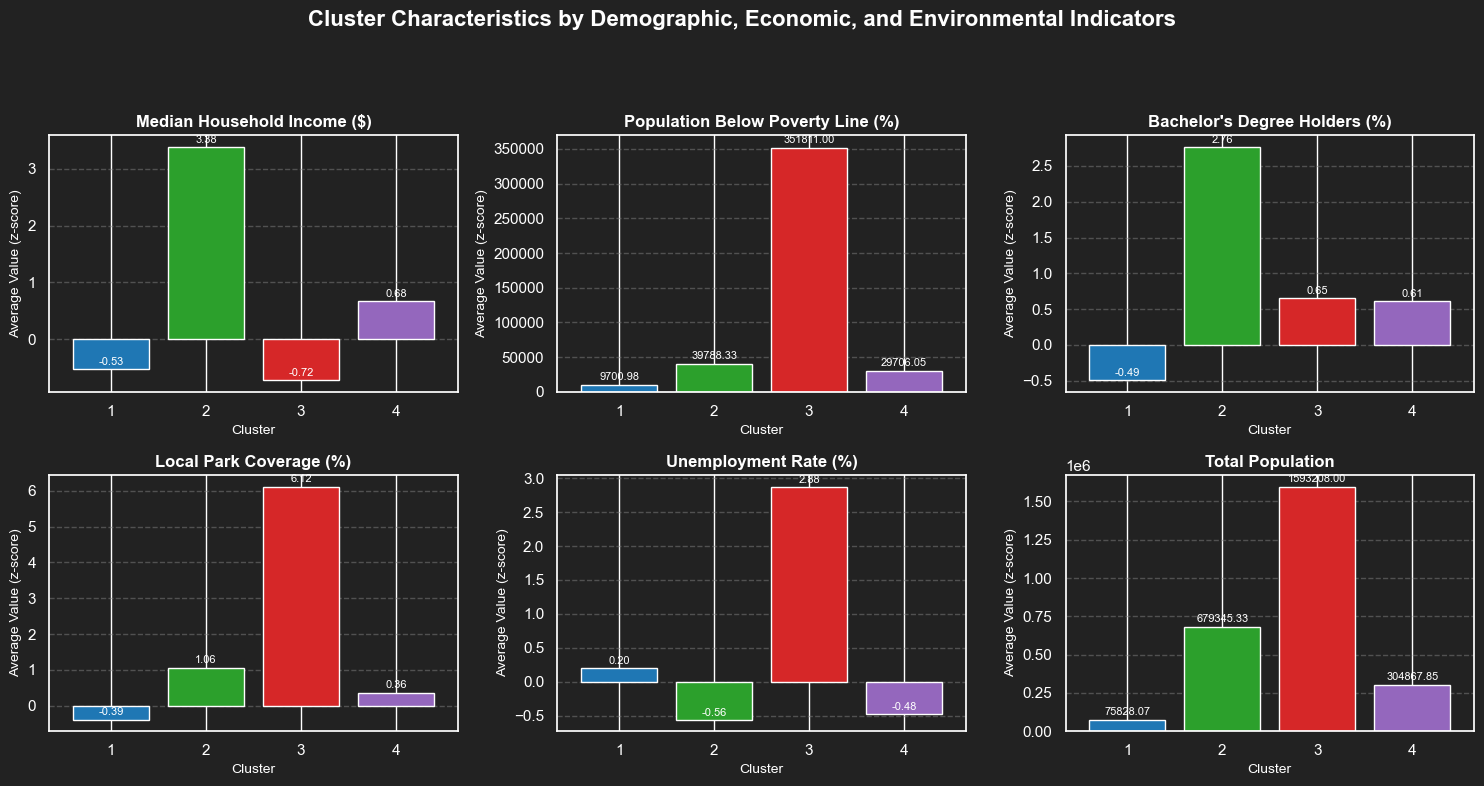

In [31]:
#| echo: true
#| code-fold: true
cluster_summary = pa_counties.groupby('Cluster')[[
    'Median Household Income', 
    'Population Below Poverty Line', 
    'Percent_Bachelors', 
    'Percent Local Park',
    'Unemp Rate',
    'Total Population'
]].mean()

cluster_summary = cluster_summary.rename(columns={
    'Median Household Income': 'Median Household Income ($)',
    'Population Below Poverty Line': 'Population Below Poverty Line (%)',
    'Percent_Bachelors': "Bachelor's Degree Holders (%)",
    'Percent Local Park': 'Local Park Coverage (%)',
    'Unemp Rate': 'Unemployment Rate (%)',
    'Total Population': 'Total Population'
})

print("Within-Cluster Characteristics Summary:")
print(cluster_summary)

sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#222222", "figure.facecolor": "#222222"})

cluster_colors = {
    1: "#1f77b4",  
    2: "#2ca02c",  
    3: "#d62728",  
    4: "#9467bd"   
}
colors = [cluster_colors[i] for i in range(1, 5)]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Cluster Characteristics by Demographic, Economic, and Environmental Indicators", fontsize=16, fontweight='bold', color='white')

variables = cluster_summary.columns
for ax, var in zip(axes.flatten(), variables):
    bars = cluster_summary[var].plot(kind='bar', ax=ax, color=colors, width=0.8)
    ax.set_title(var, fontsize=12, fontweight='bold', color='white')
    ax.set_xlabel("Cluster", fontsize=10, color='white')
    ax.set_ylabel("Average Value (z-score)", fontsize=10, color='white')
    ax.tick_params(axis='x', rotation=0, colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(axis='y', linestyle='--', alpha=0.5, color='gray')  
    
    for bar in bars.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.02 * max(cluster_summary[var]), 
            f"{bar.get_height():.2f}", 
            ha='center', fontsize=8, color='white'
        )

for ax in axes.flatten()[len(variables):]:
    ax.axis("off")
    ax.set_facecolor('#222222')
    
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

Based on the clustering analysis and visualizations of demographic, economic, and environmental characteristics across Pennsylvania counties, here are the key insights and policy recommendations:

**Cluster 1 (Blue)**

- Characteristics: This cluster shows below average median household income and bachelor’s degree attainment, relatively low poverty rates, and moderate park coverage. Unemployment rates are below average, and the total population is small.

- Policy Recommendation: Counties in this cluster appear to need more economic stability with more access to education  and green spaces. Policies could focus on increasing fund allocation to public schools.

**Cluster 2 (Green)**

- Characteristics: This cluster has high household income and low unemployment rates, high lower bachelor’s degree attainment, and high park coverage. Poverty rates are relatively low.

- Policy Recommendation: These areas need minimal policy intervention and can serve as a model for how to better allocate resources in other Pennsylvania counties.

**Cluster 3 (Red)**

- Characteristics: This cluster faces significant economic challenges, with the lowest median income and high poverty levels. While park coverage is high and educational attainment is fair, unemployment rates are also quite high.


- Policy Recommendation: The county of Philadelphia should have more economic development programs, such as job creation initiatives and small business support.

**Cluster 4 (Purple)**

- Characteristics: This cluster is defined by having relatively average socio-economic success and having relatively close proximity to key cities in the state. Median household income is slightly high compared to the other clusters.

- Policy Recommendation: Policies should aim to reduce poverty and unemployment, focusing on workforce development and job creation initiatives as well as support for affordable housing and anti-poverty programs.


**Summary and Policy Focus**

The clusters highlight areas of Pennsylvania that vary widely in socioeconomic and environmental characteristics:

- Clusters 1 and 4 are clear areas of need, with high poverty and unemployment rates, calling for targeted interventions. However, one cluster is rural while the other is urban.

- Clusters 2 and 3, while more stable, would benefit from strategic investments in green infrastructure and educational initiatives to maintain and enhance their resilience.

In conclusion, this analysis will help policymakers identify and address disparities across counties, ensuring equitable distribution of resources and tailored policy actions to foster economic and social stability statewide.